In [1]:
from src import config
from src.hand_analysis.runner.run_hand_analysis import run_analysis_with_configuration_parameters

analysis = run_analysis_with_configuration_parameters(config.DATA_DIR)
experiment = analysis.experiment

2025-05-11 22:52:13,337 [INFO] root: Processing subject: 0001, group: control
2025-05-11 22:52:13,543 [INFO] root: Processing subject: 0002, group: control
2025-05-11 22:52:13,745 [INFO] root: Processing subject: 0003, group: MCI
2025-05-11 22:52:13,886 [INFO] root: Processing subject: 0004, group: MCI
2025-05-11 22:52:14,097 [INFO] root: Processing subject: 0005, group: MCI
2025-05-11 22:52:14,314 [INFO] root: Processing subject: 0006, group: control
2025-05-11 22:52:14,439 [INFO] root: Processing subject: 0007, group: control
2025-05-11 22:52:14,574 [INFO] root: Processing subject: 0008, group: MCI
2025-05-11 22:52:14,794 [INFO] root: Processing subject: 0009, group: MCI
2025-05-11 22:52:14,922 [INFO] root: Processing subject: 0010, group: control
2025-05-11 22:52:15,036 [INFO] root: Processing subject: 0011, group: MCI
2025-05-11 22:52:15,302 [INFO] root: Processing subject: 0012, group: MCI
2025-05-11 22:52:15,455 [INFO] root: Processing subject: 0013, group: MCI
2025-05-11 22:52:1

Metrics DataFrame:
  subject_id  trial_id trial_type  age gender  is_valid  \
0       0001         8     PART_A   35      M      True   
1       0001         7     PART_B   35      M      True   
2       0001        11     PART_A   35      M      True   
3       0001        21     PART_B   35      M      True   
4       0001         1     PART_A   35      M      True   

   trial_order_of_appearance  speed_threshold  zigzag_amplitude  \
0                          2         0.262139               NaN   
1                          3         0.262139          1.166154   
2                          4         0.262139               NaN   
3                          5         0.262139          1.125605   
4                          6         0.262139               NaN   

   total_distance  ...  state_transitions  hesitation_ratio  \
0        2.078944  ...               12.0          0.746344   
1        1.714647  ...               13.0          0.406230   
2        2.069694  ...            

In [2]:

from neurotask.tmt.metrics.speed_metrics import calculate_speeds_between_cursor_positions, \
    calculate_accelerations_between_cursor_positions
from matplotlib import pyplot as plt
from build.lib.neurotask.tmt.model.tmt_model import TMTTrial


def plot_with_color(trial: TMTTrial, canvas_size: int, target_radius: float, color_by='time'):
    """
    Plotea la trayectoria del cursor junto con los targets en un gráfico,
    ajustando el tamaño del gráfico al tamaño del canvas y dibujando círculos
    alrededor de los targets con su contenido. La trayectoria del cursor se
    dibuja con puntos cuyos colores cambian en función del tiempo, la velocidad o la aceleración.
    El primer clic en el target se destaca con un marcador especial.

    Parameters:
    - trial: TMTTrial, el trial con la trayectoria del cursor y los targets.
    - canvas_size: int, tamaño del canvas (ancho y alto).
    - target_radius: float, radio de los círculos que rodean los targets.
    - color_by: str, 'time', 'speed' o 'acceleration', determina si el color de los puntos cambia en función del tiempo, velocidad o aceleración.
    """

    # Extraer la posición de los targets
    target_x = [target.position.x for target in trial.stimuli]
    target_y = [target.position.y for target in trial.stimuli]
    target_contents = [target.content for target in trial.stimuli]

    cursor_trail_from_first_click = trial.get_cursor_trail_from_start()
    # Extraer la trayectoria del cursor
    cursor_x = [cursor_info.position.x for cursor_info in cursor_trail_from_first_click]
    cursor_y = [cursor_info.position.y for cursor_info in cursor_trail_from_first_click]
    cursor_times = [cursor_info.time for cursor_info in cursor_trail_from_first_click]

    if color_by == 'time':
        # Normalizar tiempos para que estén en el rango [0, 1]
        norm = plt.Normalize(min(cursor_times), max(cursor_times))
        colors = plt.cm.viridis(norm(cursor_times))  # Usar un mapa de colores para el tiempo
    elif color_by == 'speed':
        speeds = calculate_speeds_between_cursor_positions(trial)
        speeds = [0] + speeds  # Para igualar el número de puntos con las velocidades calculadas
        norm = plt.Normalize(min(speeds), max(speeds))
        colors = plt.cm.viridis(norm(speeds))  # Usar un mapa de colores para la velocidad
    elif color_by == 'acceleration':
        accelerations = calculate_accelerations_between_cursor_positions(trial)
        accelerations = [0, 0] + accelerations  # Igualar el número de puntos (2 primeros puntos sin aceleración)
        norm = plt.Normalize(min(accelerations), max(accelerations))
        colors = plt.cm.viridis(norm(accelerations))  # Usar un mapa de colores para la aceleración
    else:
        #do not color
        # all white
        norm = plt.Normalize(0, 1)
        colors = ['white'] * len(cursor_x)
        

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dibujar la trayectoria del cursor como líneas coloreadas por tiempo o velocidad
    for i in range(len(cursor_x) - 1):
        plt.plot([cursor_x[i], cursor_x[i + 1]],
                 [cursor_y[i], cursor_y[i + 1]],
                 color=colors[i], linewidth=2, zorder=4)

    # Dibujar los targets como círculos con el contenido dentro
    for x, y, content in zip(target_x, target_y, target_contents):
        circle = plt.Circle((x, y), target_radius, color='red', alpha=0.3, zorder=5)
        plt.gca().add_patch(circle)
        # Añadir el contenido del target en el centro del círculo
        plt.text(x, y, content, color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Destacar el primer clic
    if trial.start:
        fc_x = trial.start.position.x
        fc_y = trial.start.position.y
        plt.scatter(fc_x, fc_y, color='cyan', edgecolor='black', s=100, label='First Click', zorder=7,
                    marker='o', alpha=0.3)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar_label = 'Time' if color_by == 'time' else 'Speed' if color_by == 'speed' else 'Acceleration'
    cbar = fig.colorbar(sm, ax=ax, label=cbar_label)

    # # Set plot limits based on canvas size
    # ax.set_xlim(-canvas_size, canvas_size)
    # ax.set_ylim(canvas_size, -canvas_size,)  # Inverted Y-axis if needed

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Trail with Targets')

    # Ensure equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Add legend
    ax.legend()

    return fig

In [3]:
from src.hand_analysis.loader.load_last_split import load_last_analysis
train_set, _ = load_last_analysis()

2025-05-11 22:52:43,749 [INFO] root: Loading split from /home/gianluca/Research/tmt-analysis/data/hand_analysis/2025-05-11_15-56-57


Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Correct targets touches from analysis: 8.0
Wrong targets touches from analysis: 1.0


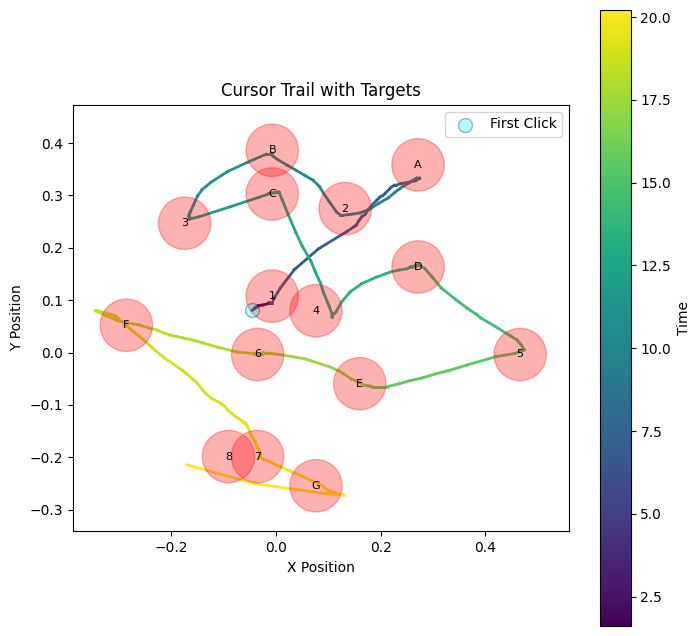

Trial ID: 0
Trial Type: TrialType.PART_A
Trial order: 16
Correct targets touches from analysis: 8.0
Wrong targets touches from analysis: 1.0


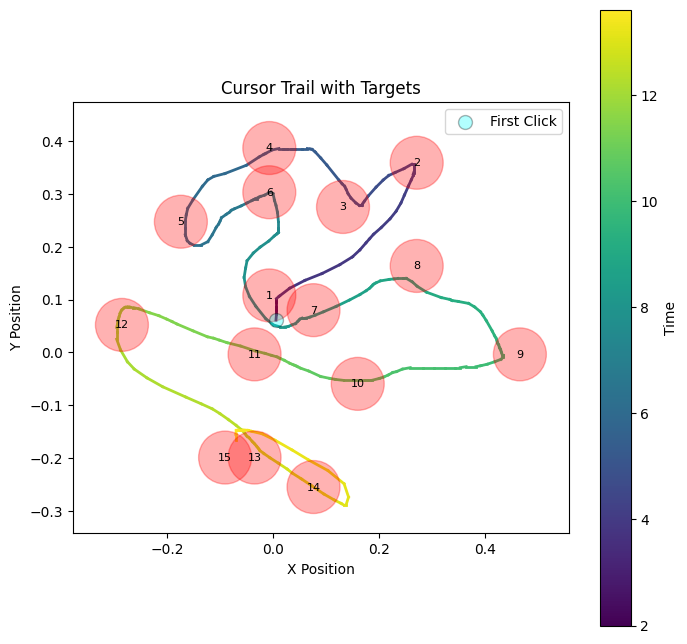

Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Correct targets touches from analysis: 8.0
Wrong targets touches from analysis: 4.0


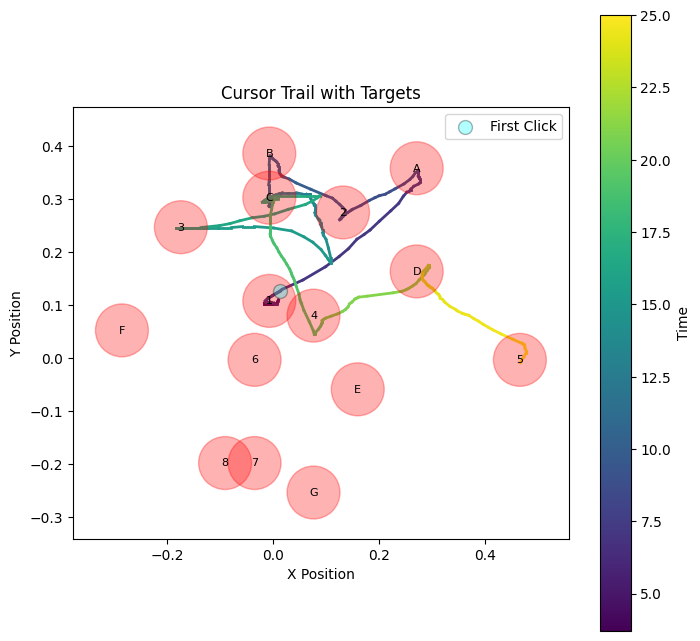

In [4]:

for subject_id in ["0063", "0091", "0022"]:
    subject_analysis = train_set[train_set['subject_id'] == int(subject_id)]
    subject = experiment.subjects[subject_id]
    for trial in sorted(subject.testing_trials, key=lambda x: x.id):
        print("Trial ID:", trial.id)
        print("Trial Type:", trial.trial_type)
        print("Trial order:", trial.order_of_appearance)
        print("Correct targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['correct_targets_touches'].values[0])
        print("Wrong targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['wrong_targets_touches'].values[0])
    
        plot_with_color(trial, subject.canvas_size, subject.target_radius)
        plt.show()
        break


In [5]:
import numpy as np
from typing import List, Tuple

def get_ideal_target_segments(
    trial: TMTTrial,
    num_interpolation_points: int = 20
) -> List[List[Tuple[float, float]]]:
    """
    Genera los segmentos ideales de recorrido entre targets consecutivos
    usando interpolación lineal.

    :param trial: TMTTrial con la lista de stimuli en orden de ejecución.
    :param num_interpolation_points: número de puntos a interpolar por segmento
                                     (incluyendo los extremos).
    :return: Lista de segmentos; cada segmento es una lista de (x, y) interpolados.
    """
    segments: List[List[Tuple[float, float]]] = []
    stimuli = trial.stimuli

    # Si hay menos de 2 targets, no hay segmentos
    if len(stimuli) < 2:
        return segments

    # Para cada par consecutivo de targets
    for start_tgt, end_tgt in zip(stimuli[:-1], stimuli[1:]):
        x0, y0 = start_tgt.position.x, start_tgt.position.y
        x1, y1 = end_tgt.position.x,   end_tgt.position.y

        # Generar valores lineales entre x0→x1 y y0→y1
        xs = np.linspace(x0, x1, num=num_interpolation_points)
        ys = np.linspace(y0, y1, num=num_interpolation_points)

        # Combinar en lista de tuplas y guardarla
        segment = [(float(x), float(y)) for x, y in zip(xs, ys)]
        segments.append(segment)

    return segments


In [6]:
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np
def plot_trial_with_ideal_path(
    trial: TMTTrial,
    num_interpolation_points: int = 20,
    show_actual_path: bool = True
) -> None:
    """
    Grafica un trial mostrando:
      - Las posiciones de los targets (estímulos) como puntos.
      - El camino ideal (interpolación lineal entre cada par de targets).
      - Opcionalmente, la trayectoria real del cursor.

    :param trial: instancia de TMTTrial a graficar.
    :param num_interpolation_points: resolución de la interpolación lineal.
    :param show_actual_path: si es True, sobrepone la trayectoria real del cursor.
    """
    # Obtener posiciones de los targets
    xs_targets = [t.position.x for t in trial.stimuli]
    ys_targets = [t.position.y for t in trial.stimuli]

    # Obtener segmentos ideales
    ideal_segments: List[List[Tuple[float, float]]] = \
        get_ideal_target_segments(trial, num_interpolation_points)

    # Empieza la figura
    plt.figure()
    # Graficar targets
    plt.scatter(xs_targets, ys_targets, marker='o', label='Targets')

    # Graficar caminos ideales
    for segment in ideal_segments:
        xs, ys = zip(*segment)
        plt.plot(xs, ys, linestyle='-', label='Ideal path' if segment is ideal_segments[0] else "")

    # Graficar trayectoria real si se desea
    if show_actual_path:
        # suponiendo que trial.get_cursor_trail_from_start() da una lista de CursorInfo con .position
        trail = trial.get_cursor_trail_from_start()
        xs_real = [ci.position.x for ci in trail]
        ys_real = [ci.position.y for ci in trail]
        plt.plot(xs_real, ys_real, linestyle='--', label='Actual path')

    # Ajustes finales
    plt.title(f"Trial {trial.id}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')  # para mantener proporción real
    plt.legend()
    plt.show()


In [7]:
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_trial_with_ideal_and_actual(
    trial: TMTTrial,
    canvas_size: int,
    target_radius: float,
    color_by: str = 'time',
    num_interpolation_points: int = 20
) -> plt.Figure:
    """
    Usa `plot_with_color` para dibujar la trayectoria real coloreada,
    y sobrepone el camino ideal interpolado entre cada par consecutivo
    de targets.

    :param trial: TMTTrial
    :param canvas_size: tamaño del canvas
    :param target_radius: radio de los círculos de los targets
    :param color_by: 'time', 'speed' o 'acceleration'
    :param num_interpolation_points: resolución de la interpolación ideal
    :return: objeto matplotlib Figure
    """
    # 1) Grafica la trayectoria real y los targets
    fig = plot_with_color(trial, canvas_size, target_radius, color_by)
    ax = fig.axes[0]

    # 2) Calcula los segmentos ideales con interpolación lineal
    ideal_segments: List[List[Tuple[float, float]]] = \
        get_ideal_target_segments(trial, num_interpolation_points)

    # 3) Sobrepone el camino ideal
    first = True
    for segment in ideal_segments:
        xs, ys = zip(*segment)
        ax.plot(
            xs, ys,
            linestyle='--',
            linewidth=2,
            color='black',
            label='Ideal path' if first else None,
            zorder=3
        )
        first = False

    # 4) Ajusta leyenda (evitar duplicados)
    handles, labels = ax.get_legend_handles_labels()
    # Filtrar etiquetas únicas
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    return fig


In [12]:
from neurotask.tmt.model.tmt_model import TMTTarget, CursorInfo, TMTTrial
from neurotask.tmt.metrics.targets_touch_calculator import get_all_trails_between_targets

import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_segments_between_targets(
    trial: TMTTrial,
    canvas_size: int,
    target_radius: float
) -> plt.Figure:
    """
    Dibuja la trayectoria real coloreada (usando plot_with_color)
    y sobrepone cada segmento entre targets con un color distinto.

    :param trial: instancia de TMTTrial
    :param canvas_size: tamaño del canvas
    :param target_radius: radio para detección de toques
    :param color_by: 'time', 'speed' o 'acceleration'
    :return: objeto Figure de matplotlib
    """
    # Primeramente dibujamos la base (trayectoria + targets)
    fig = plot_with_color(trial, canvas_size, target_radius, None)
    ax = fig.axes[0]

    # Obtenemos los segmentos ideales de recorrido real entre targets
    segments: List[Tuple[TMTTarget, List[CursorInfo]]] = \
        get_all_trails_between_targets(trial, target_radius)
    print(segments)

    # Usamos un colormap cualitativo para distinguir segmentos
    cmap = plt.get_cmap('tab10')
    
    for idx, (target, cursor_segment) in enumerate(segments):
        xs = [ci.position.x for ci in cursor_segment]
        ys = [ci.position.y for ci in cursor_segment]
        color = cmap(idx % cmap.N)
        ax.plot(
            xs, ys,
            linestyle='-',
            linewidth=5,
            color=color,
            label=f"To {target.content}"
        )

    # Ajustar leyenda para no duplicar etiquetas
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    return fig


Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Correct targets touches from analysis: 8.0
Wrong targets touches from analysis: 1.0


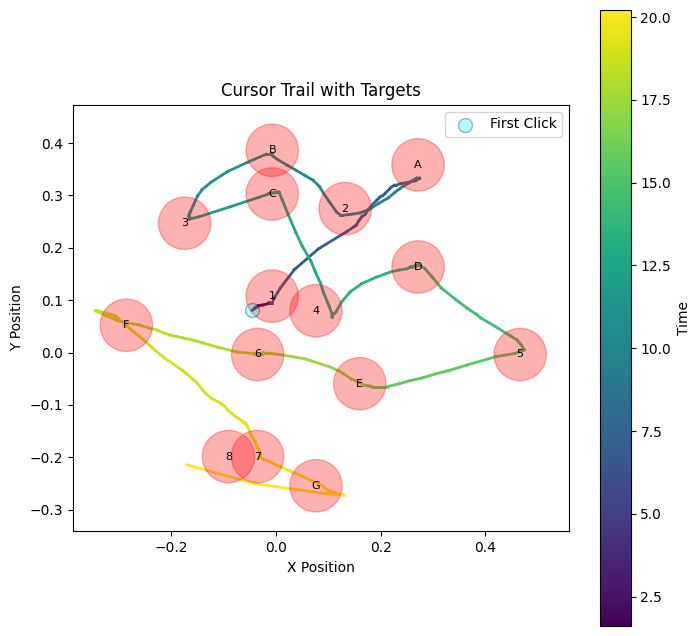

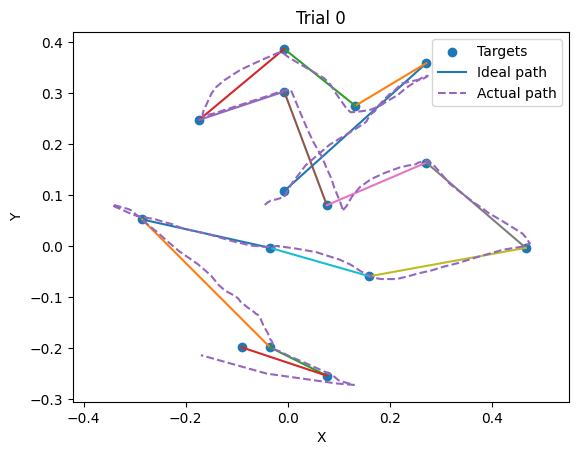

[(TMTTarget(content='A', position=Coordinate(x=0.2713626666666667, y=0.35828533333333323)), [CursorInfo(position=Coordinate(x=-0.04537037, y=0.08055556), time=1.6132666999474168), CursorInfo(position=Coordinate(x=-0.041666668, y=0.083333336), time=1.6465799999423325), CursorInfo(position=Coordinate(x=-0.039814815, y=0.085185185), time=1.6799576999619603), CursorInfo(position=Coordinate(x=-0.03888889, y=0.08611111), time=1.713031499646604), CursorInfo(position=Coordinate(x=-0.037962962, y=0.08611111), time=1.746553699951619), CursorInfo(position=Coordinate(x=-0.036111113, y=0.087037034), time=1.779952900018543), CursorInfo(position=Coordinate(x=-0.03425926, y=0.08888889), time=1.8130545997992158), CursorInfo(position=Coordinate(x=-0.03425926, y=0.08888889), time=1.8463760996237397), CursorInfo(position=Coordinate(x=-0.03425926, y=0.08888889), time=1.8799278000369668), CursorInfo(position=Coordinate(x=-0.032407407, y=0.08981481), time=1.913238599896431), CursorInfo(position=Coordinate(x=

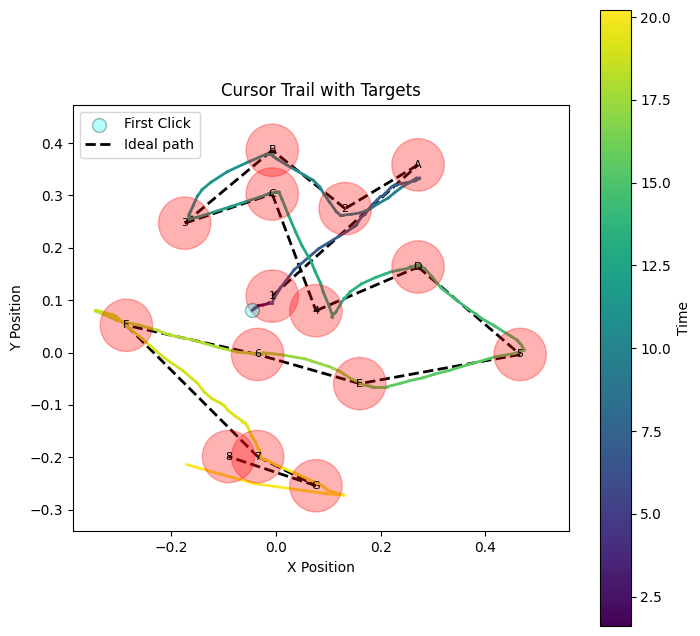

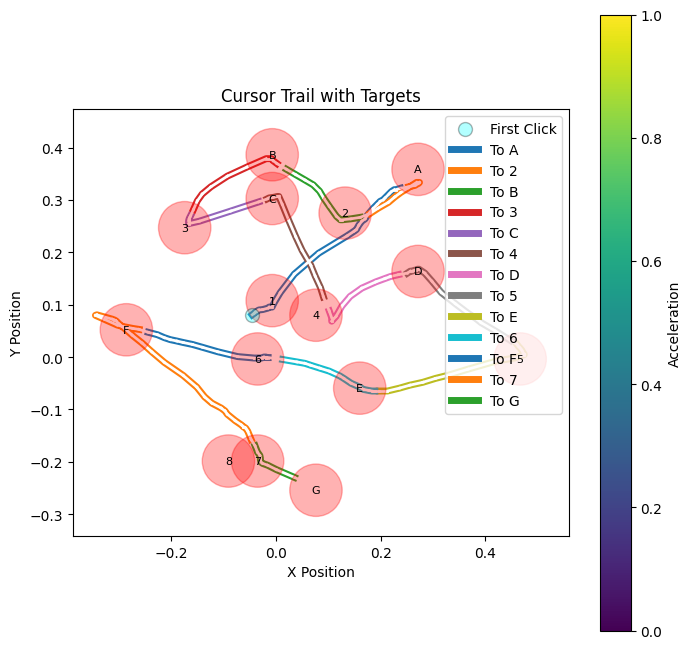

In [15]:


for subject_id in ["0063", "0091", "0022"]:
    subject_analysis = train_set[train_set['subject_id'] == int(subject_id)]
    subject = experiment.subjects[subject_id]
    for trial in sorted(subject.testing_trials, key=lambda x: x.id):
        print("Trial ID:", trial.id)
        print("Trial Type:", trial.trial_type)
        print("Trial order:", trial.order_of_appearance)
        print("Correct targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['correct_targets_touches'].values[0])
        print("Wrong targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['wrong_targets_touches'].values[0])
    
        plot_with_color(trial, subject.canvas_size, subject.target_radius)
        plot_trial_with_ideal_path(trial, num_interpolation_points=50, show_actual_path=True)
        plot_trial_with_ideal_and_actual(trial, subject.canvas_size, subject.target_radius, color_by='time', num_interpolation_points=50)
        plot_segments_between_targets(trial, subject.canvas_size, subject.target_radius)
        break
        
    break

    